In [19]:
# Tristan Wellman, BCB group, National Phenology Network project basic statistical tests
# Purpose: compares raster statistics for surrounding vector features (polygons, level III ecoregions) 
#          using interior raster cells vs (inner + poly intersecting) raster cells
# Question: will including intersecting raster cells create a measurable difference on the calcs
# Status: working draft, requires additional modification and QA/QC prior to external distribution

# Update date: Dec 1, 2016

# Input specifications (specs in cell below): 
#    (a) set working directory
#    (b) specify local shapfile
#    (c) set data year (NPN data used in test analysis)

# operations:
#    (a) reads a raster file from NPN Geoserver and local vector file (shapefile)
#    (b) extracts intersecting raster cells per (shapefile) feature (e.g. watershed, ecoregion)
#    (c) calulates basic stat measures for raster cells within each feature
#    (d) compares results using only interior vs (inner + intersecting) raster cells
#    (e) creates histograms of differences by feature between methods per statistic evaluation


In [20]:
# import python modules
import os
import requests
import rasterio.tools.mask
import rasterio
import numpy as np
import random
from pprint import pprint
import pandas
import datetime
import fiona
import rasterstats
from osgeo import osr, gdal
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from rasterstats import zonal_stats
from timeit import default_timer as timer

# dataframe/output settings
pandas.set_option('display.expand_frame_repr', False)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_row', None)
pandas.set_option('display.width',200)
pandas.set_option('precision',2)
np.set_printoptions(precision=1)

tstamp = []
tasklist = []
tasklist.append('time to retrieve + load + process data, perform stats, create dictionaries,' 
                ' create dataframes, and generate multiple plots for all ecoregions')

In [21]:
# Load data, locally for now to match local psql database

# ***************************************
# specifications - temporary for testing
# ***************************************

# feature s.f.r. uuid label attribute  name
uuid = u'URI'

# feature name label attribute  
feat_name = u'FIRST_US_1'

# npn data year
year = 2015

# ssl certificate default = True, or set path or set False 
path2cert = True

# ***************************************

# working directory
os.chdir("/Users/twellman/Documents/BCB_data_projects/NPN_BCB/")

# save figure as 
fname = 'NPN_2015_85poly_L3eco_TEST'

# shapefile with uuid
shp = 'us_eco_l3_NAD83_Dissolve/us_eco_l3_NAD83_Dissolve.shp'
#with fiona.open(shp, "r") as shapefile:
#    for feature in shapefile:
#        print feature['properties']
        
# load raster
raster = ''.join(['https://geoserver.usanpn.org/geoserver/wcs?service=WCS&version=2.0.1&request=GetCoverage&coverageId=',
                  'si-x:average_leaf_prism&time=', str(year), '-01-01&format=geotiff'])
print('\nRetrieving raster:')
req = requests.get(raster, verify = path2cert)
with open("NPN.tiff", 'wb') as f:
    f.write(req.content)
f.close()
print('raster loaded')


# open shapefile using fiona module
# used s.f.r. unique identifier and feature name, attribute name specified above  
print('\nRetrieving shapefile:\n')
with fiona.open(shp, "r") as shapefile:
    try:
        uuid_label = [feature['properties'][uuid] for feature in shapefile]
    except Exception, e:
        print('reading shapefile attribute failed, recheck properties')
        print "********** Exception, label error: %s" % str(e)
        pass
    try:
        name_label = [feature['properties'][feat_name] for feature in shapefile]
    except Exception, e:
        print('reading shapefile attribute failed, recheck properties')
        print " ******** Exception, label error: %s" % str(e)
        pass
    try:
        uuid_label = [u.split("/")[-1] for u in uuid_label ]
    except:
        pass
      
    features = [feature["geometry"] for feature in shapefile]
    source_driver = shapefile.driver
    source_crs = shapefile.crs
    source_schema = shapefile.schema
    
    print 'uuid \tfeature name\n' 
    for n,g in zip(uuid_label, name_label):
        print '{}\t{}'.format(n,g)
    
    print('\nshapefile loaded')
    
print('\nfinished read attempts')


Retrieving raster:
raster loaded

Retrieving shapefile:

uuid 	feature name

55c77fbfe4b08400b1fd8302	Coast Range
55c77fbfe4b08400b1fd8304	Columbia Plateau
55c77fbfe4b08400b1fd8306	Blue Mountains
55c77fbfe4b08400b1fd8308	Snake River Plain
55c77fbfe4b08400b1fd830a	Central Basin and Range
55c77fc0e4b08400b1fd830c	Mojave Basin and Range
55c77fc0e4b08400b1fd830e	Northern Rockies
55c77fc0e4b08400b1fd8310	Idaho Batholith
55c77fc0e4b08400b1fd8312	Middle Rockies
55c77fc0e4b08400b1fd8314	Wyoming Basin
55c77fc0e4b08400b1fd8316	Wasatch and Uinta Mountains
55c77fc0e4b08400b1fd8318	Puget Lowland
55c77fc0e4b08400b1fd831a	Colorado Plateaus
55c77fc0e4b08400b1fd831c	Southern Rockies
55c77fc0e4b08400b1fd831e	Arizona/New Mexico Plateau
55c77fc0e4b08400b1fd8320	Arizona/New Mexico Mountains
55c77fc0e4b08400b1fd8322	Chihuahuan Deserts
55c77fc1e4b08400b1fd8324	High Plains
55c77fc1e4b08400b1fd8326	Southwestern Tablelands
55c77fc1e4b08400b1fd8328	Central Great Plains
55c77fc1e4b08400b1fd832a	Flint Hills
55c77

In [22]:
# python definitions

# convert julian day to date
def get_date(year, julian):
    return (datetime.datetime(year, 1, 1) + datetime.timedelta(julian - 1)).strftime('%b %d') 

# keys for statistics
keys_dict = ['uuid', 'feature name', 'time [year]','date (earliest)','date (latest)',
        'date (mean)','date (median)','date (mode)','date (p.10th)', 'date (p.20th)',
        'date (p.30th)','date (p.40th)','date (p.50th)','date (p.60th)','date (p.70th)',
        'date (p.80th)','date (p.90th)','unique days [-]','unique days [%]','range days [-]',
        'stdev days [-]','raster cells, all [-]', 'raster cells, mask [-]','raster cells, data [-]']

# statistics dictionary
def create_dict(keys):
    value = [None for f in np.arange(1,len(keys))]
    result = dict(zip(keys, value))
    return result

# calculation attempt
def try_calc(func, failed, handle=lambda e : e, *args, **kwargs):
    try:
        return func(*args, **kwargs)
    except Exception as e:
        return failed 

def histogram_freq(ax,nbin, data, fcolor):
    weights = np.ones_like(data)/float(data.shape[0])
    n, bins, patches = ax.hist(data, nbin, normed=0, linewidth=0.75, facecolor=fcolor, alpha=0.75,weights=weights)
    ax.set_title(title, fontsize=15, y = 1.04)
    ax.set_ylabel(ylabeltext, fontsize=12)
    ax.set_xlabel(xlabeltext, fontsize=12)
    ax.tick_params(axis='both', labelsize=12, color='black', labelcolor='black')
    #ax.xaxis.set_major_locator(months)
    #ax.xaxis.set_major_formatter(monthsFmt)
    ax.grid(True, color='white', linestyle='-', linewidth=0.75)
    ax.set_axis_bgcolor((0.86764706,  0.87941176,  0.89901961))
    formatter = mticker.FuncFormatter(lambda v, pos: str(v * 100.0))
    ax.yaxis.set_major_formatter(formatter)
    ax.set_axisbelow(True)
    cumulative = np.cumsum(n)
    ax_sec = ax.twinx()
    ax_sec.plot(bins[:-1]+0.5*(bins[1]-bins[0]), cumulative, c='yellow', linewidth=2.0)
    ax_sec.set_ylabel('Cumulative frequency [%]',fontsize=12)
    ax_sec.yaxis.set_major_formatter(formatter) 
    legend1 = ax.legend(['bin'], loc="lower center", bbox_to_anchor=(0.88,0.79), shadow=True, frameon=True, 
                fontsize=12, framealpha = 1.0, numpoints = 1)
    legend2 = ax_sec.legend(['cumulative'], loc="lower center", bbox_to_anchor=(0.82,0.60), shadow=True, frameon=True, 
            fontsize=12, framealpha = 1.0, numpoints = 1)
    ax.set_ylim([0.0,1.0])
    ax.set_xlim([0,25])
    ax_sec.set_ylim([0.0,1.05])
    print('Calc check: sum bin (discrete) probability [%]:', np.sum(n)*100.0)
    return


In [23]:
# Example to calculate extended basic stats using numpy, fiona, and rasterio

#loop through polygons (features) as GeoJSON geometries

def raster_calc_summary(method):

    stat_summary = []
    with rasterio.open("NPN.tiff") as src:

        out_meta = src.meta.copy() # file metadata

        for i,f in enumerate(features):
            # structure dictionary
            results = {}
            results = create_dict(keys_dict)
            results.update({'time [year]': year, 'uuid': uuid_label[i], 'feature name': name_label[i]})

            # retrieve raster cell data within vector feature
            try:
                out_image, out_transform =rasterio.mask.mask(src, [f], crop=True, all_touched=method)
            except:
                continue

            # reshape / partition data array
            nomask_data = out_image[out_image != out_meta['nodata']]
            data_poly_all = np.reshape(out_image, (np.product(out_image.shape),))
            data_poly_nomask = np.reshape(nomask_data,(np.product(nomask_data.shape),))

            # perform basic statistics
            if data_poly_nomask.size:

                # first,last days
                mind = np.min(data_poly_nomask)
                maxd = np.max(data_poly_nomask)

                # most, least frequent days, check redundancy later
                c = Counter(data_poly_nomask)
                val_1, count1 = c.most_common()[0]
                val_2, count2 = c.most_common()[len(c)-1]

                # date conversion from year + julian day
                perc = np.percentile(data_poly_nomask,np.arange(10,100,10)).tolist()
                pdate = [get_date(results['time [year]'], p)  for p in perc]

                mean = np.mean(data_poly_nomask)
                median = np.median(data_poly_nomask)

                # statistics per feature
                update_dict = {}
                update_dict = {'date (earliest)' : mind,  
                    'date (latest)' : maxd, 
                    'date (mean)'   : mean, 
                    'date (median)' : median, 
                    'date (mode)'   : val_1, 
                    'date (p.10th)' : perc[0],
                    'date (p.20th)' : perc[1],
                    'date (p.30th)' : perc[2],
                    'date (p.40th)' : perc[3],
                    'date (p.50th)' : perc[4], 
                    'date (p.60th)' : perc[5],
                    'date (p.70th)' : perc[6],
                    'date (p.80th)' : perc[7],
                    'date (p.90th)' : perc[8],
                    'stdev days [-]'  : np.std(data_poly_nomask),
                    'unique days [-]' : len(np.unique(data_poly_nomask)),                     
                    'unique days [%]' : len(np.unique(data_poly_nomask))*100.0/len(data_poly_nomask),
                    'range days [-]'  : maxd - mind, 
                    'stdev days [-]'  : np.std(data_poly_nomask),
                    'raster cells, all [-]'  : len(data_poly_all),
                    'raster cells, mask [-]' : len(data_poly_all) - len(data_poly_nomask),
                    'raster cells, data [-]' : len(data_poly_nomask),
                    }
                results.update(update_dict)

            else:
                results['count_mask'] = len(data_poly_all)

            #print 'processing uuid: ' , uuid_label[i]
            stat_summary.append(results)
    
    return stat_summary



In [24]:
stat_true = raster_calc_summary(True)
print 'Analysis all touched completed'

stat_false = raster_calc_summary(False)
print 'Analysis all touched completed'


Analysis all touched completed
Analysis all touched completed


In [25]:
# set test keys to examine differences in  statistics
test_keys = ['date (earliest)','date (latest)',
        'date (mean)','date (median)','date (mode)','date (p.10th)', 'date (p.20th)',
        'date (p.30th)','date (p.40th)','date (p.50th)','date (p.60th)','date (p.70th)',
        'date (p.80th)','date (p.90th)','unique days [-]','unique days [%]','range days [-]',
        'stdev days [-]','raster cells, all [-]', 'raster cells, mask [-]',
        'raster cells, data [-]']

stat_diff = []
for i,s in enumerate(stat_true):
    stat_diff.append(s)
    for t in test_keys:
        stat_diff[i][t] = abs(s[t]-stat_false[i][t])*100.0/s[t]

print 'differences calculated'

differences calculated


In [26]:
# sample of stat differences
stat_diff

[{'date (earliest)': 0.0,
  'date (latest)': 45.652173913043477,
  'date (mean)': 0.70539250784841767,
  'date (median)': 0.0,
  'date (mode)': 25.0,
  'date (p.10th)': 4.0,
  'date (p.20th)': 2.941176470588063,
  'date (p.30th)': 0.0,
  'date (p.40th)': 0.0,
  'date (p.50th)': 0.0,
  'date (p.60th)': 0.0,
  'date (p.70th)': 2.209944751381729,
  'date (p.80th)': 0.0,
  'date (p.90th)': 0.0,
  'feature name': u'Coast Range',
  'range days [-]': 55.263157894736842,
  'raster cells, all [-]': 0.0,
  'raster cells, data [-]': 16.401236035179462,
  'raster cells, mask [-]': 4.029903048709263,
  'stdev days [-]': 29.60553911719461,
  'time [year]': 2015,
  'unique days [%]': 21.00632507336334,
  'unique days [-]': 33.9622641509434,
  'uuid': u'55c77fbfe4b08400b1fd8302'},
 {'date (earliest)': 0.0,
  'date (latest)': 8.0357142857142865,
  'date (mean)': 0.526755191098636,
  'date (median)': 0.0,
  'date (mode)': 0.0,
  'date (p.10th)': 0.0,
  'date (p.20th)': 0.0,
  'date (p.30th)': 0.0,
  'da

In [27]:
# Create Pandas dataframe from key, value dictionary (to match preliminary spatial feature registry work)

print ('\nPercent differences in data statistics per geometric feature using inner-only intersection method.\n')

dframe = pandas.DataFrame(columns = keys_dict, index=None)
for i, s in enumerate(stat_diff):
    dframe.loc[i] = pandas.Series(stat_diff[i]) 

for i,j in enumerate(keys_dict):
    try:
        dframe[keys_dict[i]] = dframe[keys_dict[i]].astype(float)
    except:
        continue
        
dframe.head(n=100) 
dframe.round(3)


Percent differences in data statistics per geometric feature using inner-only intersection method.



,uuid,feature name,time [year],date (earliest),date (latest),date (mean),date (median),date (mode),date (p.10th),date (p.20th),date (p.30th),date (p.40th),date (p.50th),date (p.60th),date (p.70th),date (p.80th),date (p.90th),unique days [-],unique days [%],range days [-],stdev days [-],"raster cells, all [-]","raster cells, mask [-]","raster cells, data [-]"
0,55c77fbfe4b08400b1fd8302,Coast Range,2015.0,0.00,45.65,7.05e-01,0.00,25.00,4.00,2.94,0.00,0.00,0.00,0.00,2.21,0.00,0.00,33.96,21.01,55.26,29.61,0.0,4.03,16.40
1,55c77fbfe4b08400b1fd8304,Columbia Plateau,2015.0,0.00,8.04,5.27e-01,0.00,0.00,0.00,0.00,0.00,1.43,0.00,0.00,0.00,1.30,0.00,9.26,1.94,13.23,3.18,0.0,5.93,7.47
2,55c77fbfe4b08400b1fd8306,Blue Mountains,2015.0,0.00,0.00,4.43e-01,1.35,0.00,1.61,0.00,0.00,1.39,1.35,0.00,0.00,0.00,0.00,0.00,6.35,0.00,1.92,0.0,7.20,5.97
3,55c77fbfe4b08400b1fd8308,Snake River Plain,2015.0,0.00,0.00,4.91e-01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.49,0.00,0.00,3.00,0.00,10.29,0.00,4.41,0.0,5.36,9.33
4,55c77fbfe4b08400b1fd830a,Central Basin and Range,2015.0,7.41,0.00,1.37e-01,0.00,0.00,0.00,1.82,0.00,0.00,0.00,0.00,0.00,0.00,1.27,2.68,0.93,1.45,1.47,0.0,5.62,3.57
5,55c77fc0e4b08400b1fd830c,Mojave Basin and Range,2015.0,5.00,0.00,6.57e-01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.27,4.04,1.09,3.39,0.0,9.40,6.06
6,55c77fc0e4b08400b1fd830e,Northern Rockies,2015.0,0.00,1.48,3.21e-01,1.14,0.00,1.32,1.25,0.00,0.00,1.14,1.04,0.00,0.00,0.00,2.70,3.14,2.50,1.95,0.0,7.52,5.67
7,55c77fc0e4b08400b1fd8310,Idaho Batholith,2015.0,1.45,0.00,8.10e-01,0.89,0.00,1.27,4.60,1.00,0.96,0.89,0.00,0.00,0.00,0.00,2.56,4.17,1.15,2.21,0.0,13.19,6.47
8,55c77fc0e4b08400b1fd8312,Middle Rockies,2015.0,1.37,0.00,1.21e+00,0.89,38.82,0.00,0.00,5.21,1.92,0.89,0.00,0.83,3.10,0.71,1.06,8.59,1.06,0.04,0.0,3.03,8.89
9,55c77fc0e4b08400b1fd8314,Wyoming Basin,2015.0,0.00,2.08,6.94e-01,0.00,0.00,0.00,0.00,1.11,1.06,0.00,1.96,0.00,1.82,1.72,9.23,3.12,4.35,4.25,0.0,6.34,6.30



Histograms of absolute percent differences between two raster intersection methods.
Subplots display distributions of differences in earliest, latest, average and median
of predicted leaf dates in using inner-only or boundary included raster cells, data = 2015.

('Calc check: sum bin (discrete) probability [%]:', 99.999999999999957)
('Calc check: sum bin (discrete) probability [%]:', 99.999999999999915)
('Calc check: sum bin (discrete) probability [%]:', 99.999999999999915)
('Calc check: sum bin (discrete) probability [%]:', 99.999999999999943)


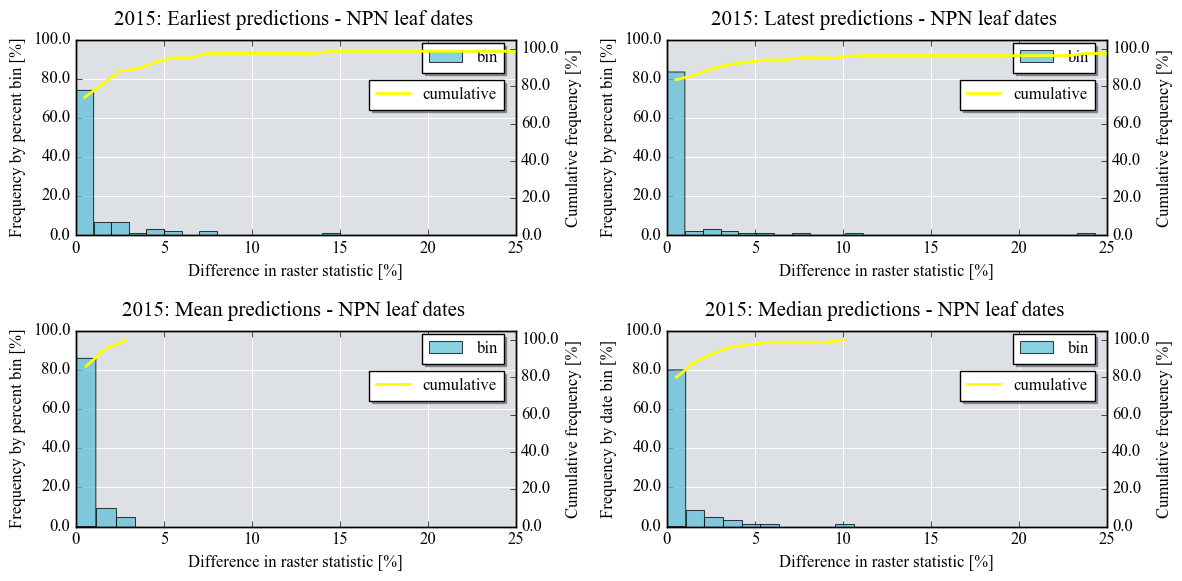

In [28]:
print ('\nHistograms of absolute percent differences between two raster intersection methods.'
       '\nSubplots display distributions of differences in earliest, latest, average and median\n'
       'of predicted leaf dates in using inner-only or boundary included raster cells, data = %s.\n' % year)

# create subplots
plt.rcParams.update({'font.family': "Times New Roman",'font.size': 12})
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6), sharex=False)
months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter("%b")

# plot summary results

binsize = 1.0 # days
fc = (0.39, .75, 0.85)

# plt 1: histogram  - frequency -  earliest
data_src = dframe['date (earliest)']
xlabeltext = 'Difference in raster statistic [%]'
ylabeltext = 'Frequency by percent bin [%]'
title = '%d: %s ' % (year, 'Earliest predictions - NPN leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax1, bins, data_src,fc)

# plt 2: histogram  - frequency -  latest
data_src = dframe['date (latest)']
xlabeltext = 'Difference in raster statistic [%]'
ylabeltext = 'Frequency by percent bin [%]'
title = '%d: %s ' % (year, 'Latest predictions - NPN leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax2, bins, data_src,fc)

# plt 3: histogram  - frequency -  mean
data_src = dframe['date (mean)']
xlabeltext = 'Difference in raster statistic [%]'
ylabeltext = 'Frequency by percent bin [%]'
title = '%d: %s ' % (year, 'Mean predictions - NPN leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax3, bins, data_src,fc)

# plt 4: histogram  - frequency -  mean
data_src = dframe['date (median)']
xlabeltext = 'Difference in raster statistic [%]'
ylabeltext = 'Frequency by date bin [%]'
title = '%d: %s ' % (year, 'Median predictions - NPN leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax4, bins, data_src,fc)

plt.subplots_adjust(left=None, bottom=0.0, right=None, top=None, wspace=0.40, hspace=0.35)
plt.savefig(fname + 'BasicStats' + '.png', format='png', dpi=450,bbox_inches='tight', pad_inches=0.2)

plt.tight_layout()
plt.show()





Histograms of absolute percent differences between two raster intersection methods.
Subplots display distributions of differences in 10th, 30th, 60th, and 90th percentiles
of predicted leaf dates in using inner-only or boundary included raster cells, data = 2015.

('Calc check: sum bin (discrete) probability [%]:', 99.999999999999957)
('Calc check: sum bin (discrete) probability [%]:', 99.999999999999915)
('Calc check: sum bin (discrete) probability [%]:', 99.999999999999915)
('Calc check: sum bin (discrete) probability [%]:', 99.999999999999915)


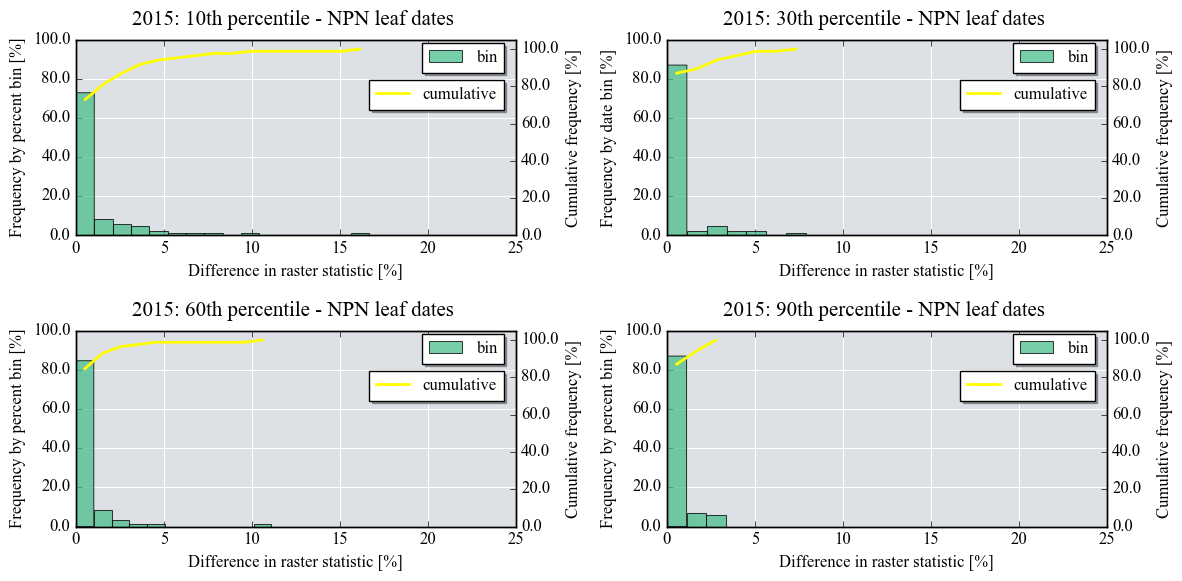

In [29]:
print ('\nHistograms of absolute percent differences between two raster intersection methods.'
       '\nSubplots display distributions of differences in 10th, 30th, 60th, and 90th percentiles\n'
       'of predicted leaf dates in using inner-only or boundary included raster cells, data = %s.\n' % year)

# create subplots
plt.rcParams.update({'font.family': "Times New Roman",'font.size': 12})
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6), sharex=False)
months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter("%b")

# plot summary results

binsize = 1.0 # days
fc = (0.29, .75, 0.55)

# plt 1: histogram  - frequency -  10th percentile
data_src = dframe['date (p.10th)']
xlabeltext = 'Difference in raster statistic [%]'
ylabeltext = 'Frequency by percent bin [%]'
title = '%d: %s ' % (year, '10th percentile - NPN leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax1, bins, data_src,fc)

# plt 2: histogram  - frequency -  latest
data_src = dframe['date (p.30th)']
xlabeltext = 'Difference in raster statistic [%]'
ylabeltext = 'Frequency by date bin [%]'
title = '%d: %s ' % (year, '30th percentile - NPN leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax2, bins, data_src,fc)

# plt 3: histogram  - frequency -  mean
data_src = dframe['date (p.60th)']
xlabeltext = 'Difference in raster statistic [%]'
ylabeltext = 'Frequency by percent bin [%]'
title = '%d: %s ' % (year, '60th percentile - NPN leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax3, bins, data_src,fc)

# plt 4: histogram  - frequency -  mean
data_src = dframe['date (p.90th)']
xlabeltext = 'Difference in raster statistic [%]'
ylabeltext = 'Frequency by percent bin [%]'
title = '%d: %s ' % (year, '90th percentile - NPN leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax4, bins, data_src,fc)

plt.subplots_adjust(left=None, bottom=0.0, right=None, top=None, wspace=0.40, hspace=0.35)
plt.savefig(fname + 'percentiles' + '.png', format='png', dpi=450,bbox_inches='tight', pad_inches=0.05)

plt.tight_layout()
plt.show()


Histograms of absolute percent differences between two raster intersection methods.
Subplots display distributions of differences in unique days, range, and standard deviation
of predicted leaf dates in using inner-only or boundary included raster cells, data = 2015.

('Calc check: sum bin (discrete) probability [%]:', 100.00000000000003)
('Calc check: sum bin (discrete) probability [%]:', 100.00000000000003)
('Calc check: sum bin (discrete) probability [%]:', 100.00000000000003)


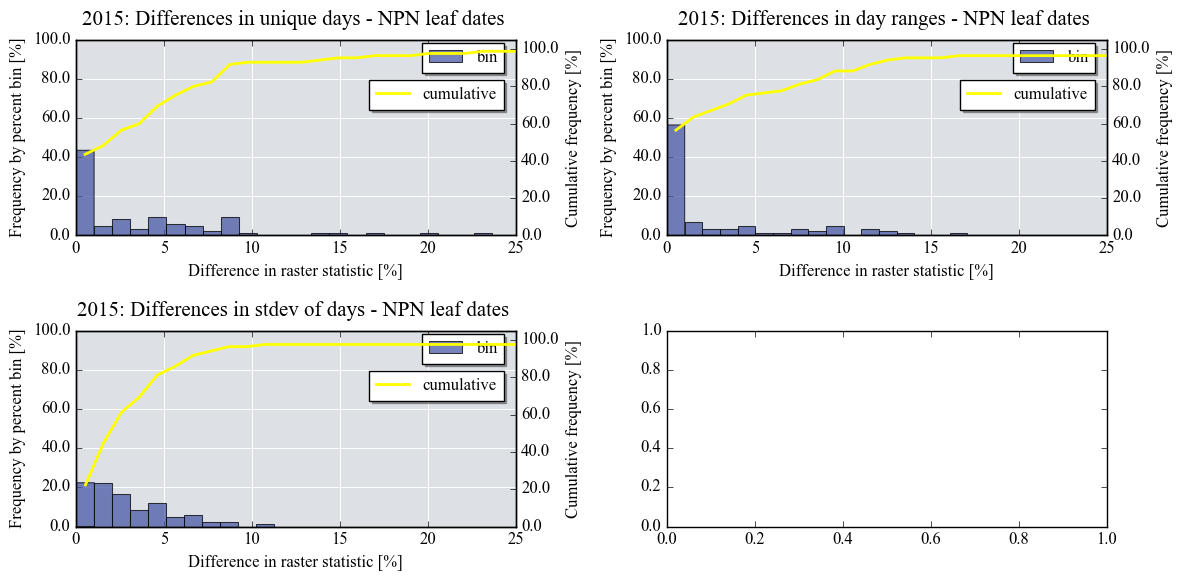

In [30]:
print ('\nHistograms of absolute percent differences between two raster intersection methods.'
       '\nSubplots display distributions of differences in unique days, range, and standard deviation\n'
       'of predicted leaf dates in using inner-only or boundary included raster cells, data = %s.\n' % year)

# create subplots
plt.rcParams.update({'font.family': "Times New Roman",'font.size': 12})
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6), sharex=False)
months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter("%b")

# plot summary results

binsize = 1.0 # days
fc = (0.29, .35, 0.65)


# plt 1: histogram  - frequency -  unique day values
data_src = dframe['unique days [-]']
xlabeltext = 'Difference in raster statistic [%]'
ylabeltext = 'Frequency by percent bin [%]'
title = '%d: %s ' % (year, 'Differences in unique days - NPN leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax1, bins, data_src,fc)

# plt 2: histogram  - frequency -  range of julian days
data_src = dframe['range days [-]']
xlabeltext = 'Difference in raster statistic [%]'
ylabeltext = 'Frequency by percent bin [%]'
title = '%d: %s ' % (year, 'Differences in day ranges - NPN leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax2, bins, data_src,fc)

# plt 3: histogram  - frequency -  standard deviation
data_src = dframe['stdev days [-]']
xlabeltext = 'Difference in raster statistic [%]'
ylabeltext = 'Frequency by percent bin [%]'
title = '%d: %s ' % (year, 'Differences in stdev of days - NPN leaf dates')
span = data_src.max() - data_src.min()
bins = np.maximum(int(span/binsize),1)
histogram_freq(ax3, bins, data_src,fc)

plt.subplots_adjust(left=None, bottom=0.0, right=None, top=None, wspace=0.40, hspace=0.35)
plt.savefig(fname + 'SpreadStats' + '.png', format='png', dpi=450,bbox_inches=None, pad_inches=0.05)

plt.tight_layout()
plt.show()


